# Ask Questions from Ramayan using LangGraph
In this project, we aim to build an intelligent agent that can read the ancient Indian epic "Ramayana - Childerens book", understand its content, and answer user questions based on it. To do this, we use a powerful Retrieval-Augmented Generation (RAG) pipeline — where the AI first retrieves relevant parts of the document, then generates an answer using a Large Language Model (LLM).

**The system not only help with the answers but at the end of the conversation, send the chat summary to your email**

To manage the control flow and modular structure of the system, we use LangGraph — a library that enables building stateful, multi-step AI workflows using a graph-based abstraction.

## Step-1: Data Ingestion
✅ Task:
1. Load the Ramayan.pdf


In [1]:
# !pip install langgraph
# !pip install --upgrade langchain langchain-core langchain-openai
# !pip install graphviz
# !pip install 'langgraph[visualization]'



In [2]:
from langchain.embeddings import SentenceTransformerEmbeddings
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import TextLoader
from langchain.document_loaders import PyMuPDFLoader
from langchain.schema import Document
import os


/home/avinash/Desktop/dr_avinash/generative_ai/lecture-8/torch/lib/python3.12/site-packages/langchain_community/embeddings/sentence_transformer.py:3: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from langchain_community.embeddings.huggingface import HuggingFaceEmbeddings


In [3]:
# Load the PDF
loader = PyMuPDFLoader("data/RAMAYANA.pdf")
documents = loader.load()

# Example: define chapters by page ranges (you can adjust this)
chapter_map = {
    "Introduction".upper(): range(0, 2),
    "THE BIRTH OF RAMA".upper(): range(2, 3),
    "The Valiant Princes".upper(): range(3, 6),
    "SITA'S SWAYAMVAR".upper(): range(6, 8),
    "KAIKEYI AND HER WISHES".upper(): range(7, 21),
    "The demons in the forests".upper(): range(21, 24),
    "The Kidnapping of Sita".upper(): range(24, 27),
    "Rama searches for Sita".upper(): range(27, 29),
    "The land of the monkeys".upper(): range(29, 33),
    "Hanuman meets Sita - Lanka is destroyed".upper(): range(33, 37),
    "The War".upper(): range(37, 46),  
}

# Assign chapter metadata
tagged_documents = []
for i, doc in enumerate(documents):
    # print(f"Processing page {i + 1} of {doc.page_content[0:50]}")
    for chapter, pages in chapter_map.items():
        pages = list(pages)
        # print("Pages:",pages)
        if i in pages:
            chapter_name = chapter
            break
        else:
            chapter_name = "Unknown Chapter"
    
    # print(f"Chapter: {chapter_name} for page {i + 1}")
    new_doc = Document(page_content=doc.page_content, metadata={"chapter": chapter_name, **doc.metadata})
    tagged_documents.append(new_doc)


## Step-2: Data Chunking (Paragraph Chunking)
✅ Task:
2. Chunk the text into manageable segments

In [4]:
# Paragraph-level splitting
def split_into_paragraphs(text):
    paragraphs = text.split("\n\n")
    return [Document(page_content=p.strip()) for p in paragraphs if p.strip()]

documents = []
for doc in tagged_documents:
    paragraphs = split_into_paragraphs(doc.page_content)
    documents.extend(paragraphs)

## Step-3: Data Storage
✅ Task:
1. Generate embeddings from the chunks
2. Store in a vector database (FAISS)

In [5]:
from langchain.embeddings import HuggingFaceEmbeddings

# Embedder and vectorstore
embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2",
                                        model_kwargs={"device": "cpu"})
vectorstore = FAISS.from_documents(documents, embedding_model)


/tmp/ipykernel_57020/2313260310.py:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2",
/home/avinash/Desktop/dr_avinash/generative_ai/lecture-8/torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 4- Define LangGraph Nodes
✅ Task:
Create LangGraph nodes:
1. retriever_node to fetch relevant chunks
2. llm_node to answer based on those chunks

In [6]:
from langchain.prompts import PromptTemplate
# Prompt template
PROMPT_TEMPLATE = """
ou are a gentle storyteller who explains things in a simple, step-by-step way that even a child can understand.
Whenever someone asks a question, you tell the answer as a short story around 100 words, using clear and easy words. Base your story only on the information provided in the context. When you refer to something from the book, kindly show the page number in square brackets like this: [Page 10].

### Context Chunks:
{context}

### Question:
{question}

### Answer:
"""

# Prompt template
prompt_template = PromptTemplate(
input_variables=["context", "question"],
template=PROMPT_TEMPLATE )

In [ ]:
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
# Shared state type
from typing import List, TypedDict, Optional
import smtplib
from email.mime.text import MIMEText


# Load OpenAI API key from a file
file = open('data/key.txt', 'r')
# Read the API key from the file
api_key = file.read().strip()
# Close the file
file.close()

file = open('data/hello.txt', 'r')
# Read the API key from the file
password = file.read().strip()
# Close the file
file.close()

# 🧠 Set your OpenAI API key
os.environ["OPENAI_API_KEY"] = api_key


retriever = vectorstore.as_retriever()
llm = ChatOpenAI(model_name="gpt-4", temperature=0.2)  # Remove openai_api_key=api_key


class RAGState(TypedDict):
    question: str # field for the question
    context_docs: List[str] # field for context documents
    answer: str # field for the answer
    chat_history: List[str]  # field for memory
    critique_llm: Optional[str]  # Field for post-analysis
    summary: Optional[str]      # Final summary


# Retrieval node
def retrieve_node(state: RAGState) -> RAGState:
    query_vector = embedding_model.embed_query(state['question'])
    docs = vectorstore.similarity_search_by_vector(query_vector, k=3)
    return {**state, "context_docs": [doc.page_content for doc in docs]}

# LLM node
def generate_answer_node(state: RAGState) -> RAGState:
    context = "\n\n".join(state["context_docs"])
    chat_history = "\n".join(state.get("chat_history", []))
    prompt = (
        f"You are a helpful assistant answering questions based on the Ramayana.\n\n"
        f"Previous conversation:\n{chat_history}\n\n"
        f"Context:\n{context}\n\n"
        f"Current Question: {state['question']}\n"
        f"Answer:"
    )
    answer = llm.invoke(prompt)
    updated_chat = state["chat_history"] + [f"Q: {state['question']}", f"A: {answer.content}"]
    return {**state, "answer": answer.content, "chat_history": updated_chat}

# Critique node
def critique_node(state: RAGState) -> RAGState:
    prompt = (
        f"As a critique assistant, rate the clarity and relevance of the following answer.\n"
        f"Question: {state['question']}\n"
        f"Answer: {state['answer']}\n"
        f"Rate from 1 (poor) to 5 (excellent) with a short justification:"
    )
    critique_response = llm.invoke(prompt)
    return {**state, "critique_llm": critique_response.content}

# Summary Node
def summary_node(state: RAGState) -> RAGState:
    full_chat = "\n".join(state["chat_history"])
    prompt = f"Summarize the following Q&A session about the Ramayana:\n\n{full_chat}\n\nSummary:"
    result = llm.invoke(prompt)
    return {**state, "summary": result.content}


# Email Agent Node
def email_node(state: RAGState) -> RAGState:
    summary = state["summary"]
    recipient = "avinashkumarsingh1986@gmail.com"  

    msg = MIMEText(summary)
    msg["Subject"] = "Your Ramayana Chat Summary"
    msg["From"] = "avinash@robaita.com"
    msg["To"] = recipient

    # Send email via Gmail SMTP
    with smtplib.SMTP_SSL("smtp.gmail.com", 465) as smtp:
        smtp.login("avinash@robaita.com", password)  
        smtp.send_message(msg)

    return state  # unchanged, email is a side effect





## Step-5: Build LangGraph DAG
✅ Task:
1. Connect the nodes using StateGraph
2. Set input/output schema

In [9]:
graph = StateGraph(RAGState)
graph.add_node("retrieve", retrieve_node)
graph.add_node("generate", generate_answer_node)
graph.add_node("critique", critique_node)
graph.add_node("SummaryAgent", summary_node)
graph.add_node("EmailAgent", email_node)


graph.set_entry_point("retrieve")
graph.add_edge("retrieve", "generate")
graph.add_edge("generate", "critique")
graph.add_edge("critique", "SummaryAgent")
graph.add_edge("SummaryAgent", "EmailAgent")

graph.set_finish_point("EmailAgent")

rag_chain = graph.compile()


## Step 6: Ask Questions with LangGraph Agent
✅ Task:
1. Provide user questions
2. Return LangGraph-generated answers

In [ ]:
# Start with an empty memory
chat_state = {
    "chat_history": [],
}

print("Welcome! Ask questions about the Ramayana (type 'exit' to stop).\n")

while True:
    user_question = input("You: ")
    if user_question.lower() in {"exit", "quit"}:
        # Run the graph
        result = rag_chain.invoke(input_state)
        break

    # Build state for this turn
    input_state = {
        "question": user_question,
        "chat_history": chat_state["chat_history"],
        "context_docs": [],
        "answer": "",
        "critique_llm": "",
    }

    # Update memory
    chat_state["chat_history"] = result["chat_history"]

    # Print response
    print(f"Assistant: {result['answer']}")
    print(f"Critique: {result['critique_llm']}\n")


Welcome! Ask questions about the Ramayana (type 'exit' to stop).



SMTPAuthenticationError: (535, b'5.7.8 Username and Password not accepted. For more information, go to\n5.7.8  https://support.google.com/mail/?p=BadCredentials d9443c01a7336-23603506d4dsm74324915ad.235 - gsmtp')

# Visualize LangGraph

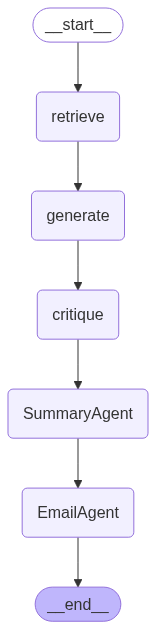

In [11]:
from IPython.display import Image, display

graph_image_data = rag_chain.get_graph().draw_mermaid_png()
display(Image(graph_image_data))

In [ ]:
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
import ssl
import os

# --- Configuration ---
# Your Gmail address
sender_email = "avinashkumarsingh1986@gmail.com"
# The App Password you generated (NOT your regular Gmail password)
# It's best practice to store this in an environment variable, not directly in code.
# Example: export GMAIL_APP_PASSWORD="your_16_char_app_password"
app_password = password

# Recipient email address
receiver_email = "avinash@robaita.com"
# Subject of the email
subject = "Test Email from Python"
# Body of the email
body = "Hello from Python!\n\nThis is a test email sent using smtplib and Gmail."

# --- Check for App Password ---
if app_password is None:
    print("Error: GMAIL_APP_PASSWORD environment variable not set.")
    print("Please set it like: export GMAIL_APP_PASSWORD=\"your_16_char_app_password\"")
    print("You can generate an App Password in your Google Account security settings.")
    exit()

# --- Create the email message ---
# For plain text
msg = MIMEText(body, 'plain')
msg['Subject'] = subject
msg['From'] = sender_email
msg['To'] = receiver_email

# If you want to send HTML or attachments, use MIMEMultipart
# msg = MIMEMultipart()
# msg['Subject'] = subject
# msg['From'] = sender_email
# msg['To'] = receiver_email
# msg.attach(MIMEText(body, 'html')) # For HTML content
# # For attachments:
# # with open("path/to/your/file.pdf", "rb") as attachment:
# #     part = MIMEBase("application", "octet-stream")
# #     part.set_payload(attachment.read())
# # encoders.encode_base64(part)
# # part.add_header(
# #     "Content-Disposition",
# #     f"attachment; filename= {os.path.basename('path/to/your/file.pdf')}",
# # )
# # msg.attach(part)


# --- Connect to Gmail's SMTP server and send the email ---
try:
    # Create a secure SSL context
    context = ssl.create_default_context()

    print(f"Attempting to connect to SMTP server {sender_email}...")
    # Use port 587 for STARTTLS
    with smtplib.SMTP("smtp.gmail.com", 587) as server:
        # Start TLS encryption
        server.starttls(context=context)
        # Login to your Gmail account
        server.login(sender_email, app_password)
        print("Logged in successfully. Sending email...")
        # Send the email
        server.send_message(msg)
        print(f"Email sent successfully to {receiver_email}!")

except smtplib.SMTPAuthenticationError:
    print("Authentication Error: Failed to log in. Check your sender_email and App Password.")
    print("Remember to use an App Password, not your regular Gmail password, if 2-Step Verification is on.")
except smtplib.SMTPConnectError as e:
    print(f"Connection Error: Could not connect to the SMTP server. {e}")
    print("Check your internet connection or try again later.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Attempting to connect to SMTP server avinashkumarsingh1986@gmail.com...
Authentication Error: Failed to log in. Check your sender_email and App Password.
Remember to use an App Password, not your regular Gmail password, if 2-Step Verification is on.
